In [2]:
import torch
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from models import Autoformer

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline

from tqdm.notebook import tqdm

In [12]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def preprocess_autoformer(df_raw, seq_len, label_len,target='e_mu_current',freq='t', device='cuda'):
    pred_len=1

    cols = list(df_raw.columns)
    cols.remove(target)
    cols.remove('date')

    df_raw = df_raw[['date'] + cols + [target]]
    border1 = len(df_raw) - seq_len - pred_len
    border2 = len(df_raw)

    cols_data = df_raw.columns[1:]
    df_data = df_raw[cols_data]

    data = df_data.values

    tmp_stamp = df_raw[['date']][border1:border2]
    tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
    pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=pred_len + 1, freq=freq)

    df_stamp = pd.DataFrame(columns=['date'])
    df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])

    df_stamp = df_raw[['date']][border1:border2]
    df_stamp['date'] = pd.to_datetime(df_stamp.date)

    df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
    df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
    df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
    df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
    df_stamp['minute'] = df_stamp.date.apply(lambda row: row.minute, 1)
    df_stamp['minute'] = df_stamp.minute.map(lambda x: x // 15)
    data_stamp = df_stamp.drop(['date'], axis=1).values

    data_x = data[border1:border2]
    data_y = data[border1:border2]

    s_begin = 0
    s_end = s_begin + seq_len
    r_begin = s_end - label_len
    r_end = r_begin + label_len + pred_len

    seq_x = data_x[s_begin:s_end]
    seq_y = data_y[r_begin:r_begin + label_len]
    seq_x_mark = data_stamp[s_begin:s_end]
    seq_y_mark = data_stamp[r_begin:r_end+1]

    batch_x = torch.FloatTensor(seq_x).unsqueeze(0).to(device)
    batch_y = torch.FloatTensor(seq_y).unsqueeze(0).to(device)
    batch_x_mark = torch.FloatTensor(seq_x_mark).unsqueeze(0).to(device)
    batch_y_mark = torch.FloatTensor(seq_y_mark).unsqueeze(0).to(device)

    dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :label_len, :], dec_inp], dim=1).float().to(device)

    return batch_x, batch_x_mark, dec_inp, batch_y_mark, batch_y

def autoformer_predict(outputs, pred_len,  batch_y, f_dim=-1, output_attention=True):
    
    if output_attention:
        outputs = outputs[0]

    outputs = outputs[:, -pred_len:, f_dim:]
    batch_y = batch_y[:, -pred_len:, f_dim:].to(device)

    pred = outputs.detach().cpu().numpy()[0][0]  # .squeeze()
    true = batch_y.detach().cpu().numpy()[0][0]  # .squeeze()
    return pred[-pred_len:], true[-pred_len:]

In [8]:
setting='qber_96_48_120_loginf_s_non_outliers_Autoformer_custom_ftMS_sl96_ll48_pl1_dm512_nh8_el6_dl6_df2048_fc1_ebtimeF_dtFalse_Exp_0'

path=f'./checkpoints/{setting}/model.pth'

seq_len=96
label_len=48
pred_len=1

# model = Autoformer.Model(args).float()
model = Autoformer.Model(
        dropout=0.05,
        freq='t',
        seq_len=seq_len,
        label_len=label_len,
        pred_len=pred_len,
        e_layers=6,
        d_layers=6,
        n_heads=8,
        factor=1,
        enc_in=6,
        dec_in=6,
        c_out=6,
        d_model=512,
        d_ff=2048,
        moving_avg=25,
        output_attention=True,
        embed='timeF',
        activation='gelu',)

model.load_state_dict(torch.load(path))

model.eval()
device='cuda'
model.to(device)


Model(
  (decomp): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(6, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=5, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(6, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=5, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encode

In [5]:
df = pd.read_csv('datasets/non_outliers_step=120_log_inf_test=0.1.csv')

In [14]:

preds = []
trues = []

with torch.no_grad():
    for i  in tqdm(range(len(df)-seq_len)):
        #
        # рабочий костыль в виде "+pred_len"
        #
        df_tmp=df.iloc[i:i+seq_len+pred_len]

        batch_x, batch_x_mark, dec_inp, batch_y_mark, batch_y=preprocess_autoformer(df_tmp,seq_len, label_len )

        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

        pred, true=autoformer_predict(outputs, pred_len,  batch_y,)

        preds.append(pred)
        trues.append(true)


  0%|          | 0/18064 [00:00<?, ?it/s]

KeyboardInterrupt: 

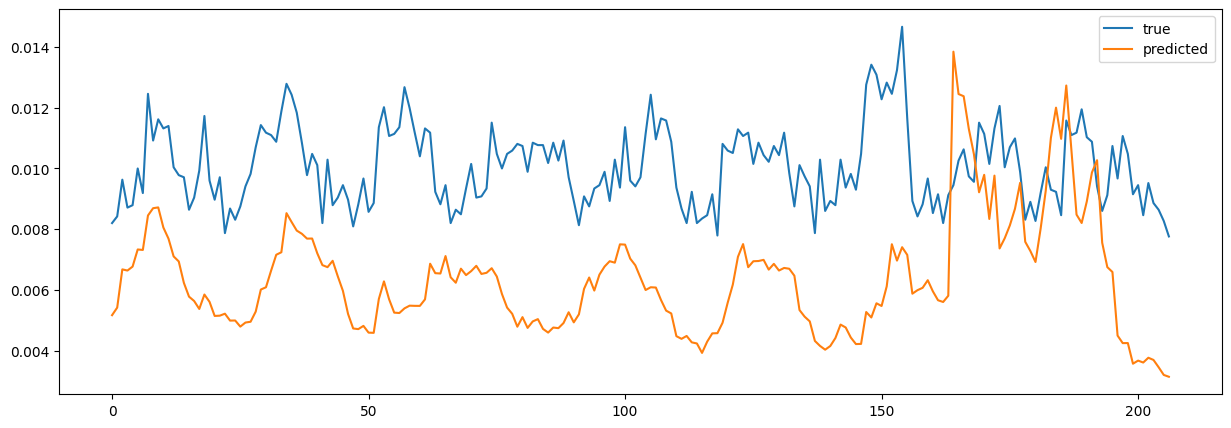

In [15]:
trues=np.array(trues)
preds=np.array(preds)
plt.figure(figsize=(15,5))

plt.plot(np.exp(trues[:,0]))
plt.plot(np.exp(preds[:,0]))
plt.legend(['true', 'predicted'])
plt.show()